In [ ]:
import tensorflow as tf

print(tf.__version__)
# 1.14.0

tf.test.is_gpu_available(
    cuda_only=False,
    min_cuda_compute_capability=None
)
# True

(2)
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
import torch
print(torch.cuda.is_available())

In [ ]:
print(torch.__version__)

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import DataLoader, Dataset
import os
from asteroid.metrics import get_metrics
from asteroid.losses import singlesrc_neg_sisdr, singlesrc_neg_snr

import numpy as np
import matplotlib.pyplot as plt
from glob import glob

from IPython.display import Audio
from tqdm import tqdm
import time
import torchaudio.transforms as T

In [13]:
import matplotlib.pyplot as plt
import torchaudio
import torch
import IPython
import librosa

In [3]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)

In [4]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

In [5]:
n_fft = 1024
win_length = None
hop_length = 512

# Define transform
spectrogram = T.Spectrogram(
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

In [6]:
audio, rate = torchaudio.load("C:/Users/USER/Desktop/continuous-audio-representations-main/results/default/all_mono2/pi-gan_sine_first/autodecoder/audio/original_0.wav")

In [7]:
IPython.display.Audio(data=audio, rate=48000)

In [ ]:
plot_waveform(audio, 48000)

In [ ]:
spec = spectrogram(audio)
plot_spectrogram(spec[0], title="torchaudio")

In [9]:
recon_audio, rate = torchaudio.load("C:/Users/USER/Desktop/continuous-audio-representations-main/results/default/all_mono2/pi-gan_sine_first/autodecoder/audio/reconstruction_epoch_10000_2.wav")

In [10]:
IPython.display.Audio(data=recon_audio, rate=48000)

In [ ]:
plot_waveform(recon_audio, 48000)

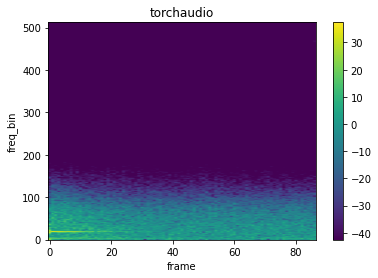

In [24]:
spec = spectrogram(audio)
plot_spectrogram(spec[0], title="torchaudio")

In [15]:
audio, rate = torchaudio.load("C:/Users/USER/Desktop/original_1.wav")

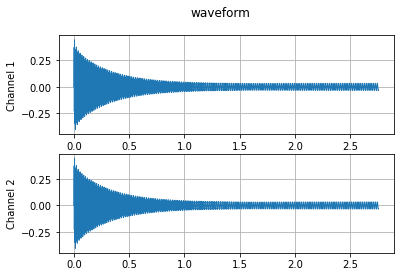

In [8]:
plot_waveform(audio, 16000)

In [17]:
audio, rate = torchaudio.load("C:/Users/USER/Desktop/wavegan-keyboard_1.wav")

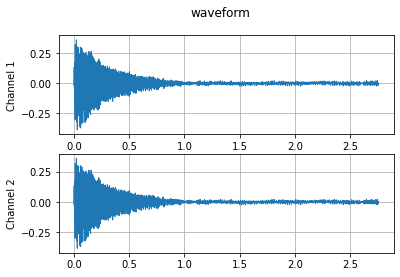

In [19]:
plot_waveform(audio, 16000)

In [27]:
audio, rate = torchaudio.load("C:/Users/USER/Desktop/wide-keyboard_1.wav")

RuntimeError: Error opening 'C:/Users/USER/Desktop/wide-keyboard_1.wav': File contains data in an unknown format.

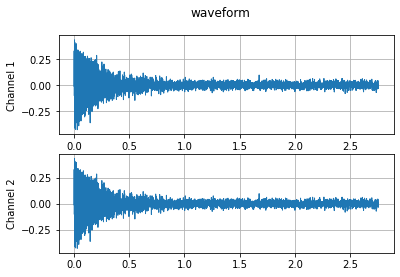

In [23]:
plot_waveform(audio, 16000)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from INR_collection import *

#=== Decoders =================================================================
class UpsampleConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample_layer = nn.Upsample(scale_factor=upsample)
            reflection_padding = kernel_size // 2
            self.reflection_pad = nn.ConstantPad1d(reflection_padding, value = 0)
            self.conv1d = nn.Conv1d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = self.upsample_layer(x_in)
        out = self.reflection_pad(x_in)
        out = self.conv1d(out)
        return out

class WaveGANGenerator(nn.Module):
    def __init__(self, model_size=64, ngpus=1, num_channels=1, latent_dim=256, audio_length=16000,
                 post_proc_filt_len=512, verbose=False, upsample=True):
        super(WaveGANGenerator, self).__init__()
        self.ngpus = ngpus
        self.model_size = model_size # d
        self.num_channels = num_channels # c
        self.latent_dim = latent_dim
        self.post_proc_filt_len = post_proc_filt_len
        self.audio_length=16000
        self.verbose = verbose

        self.fc1 = nn.DataParallel(nn.Linear(latent_dim, 256 * model_size))
        
        self.tconv1 = None
        self.tconv2 = None
        self.tconv3 = None
        self.tconv4 = None
        self.tconv5 = None
           
        self.upSampConv1 = None
        self.upSampConv2 = None
        self.upSampConv3 = None
        self.upSampConv4 = None
        self.upSampConv5 = None
        
        self.upsample = upsample
    
        if self.upsample:
            self.upSampConv1 = nn.DataParallel(
                UpsampleConvLayer(16 * model_size, 8 * model_size, 25, stride=1, upsample=4))
            self.upSampConv2 = nn.DataParallel(
                UpsampleConvLayer(8 * model_size, 4 * model_size, 25, stride=1, upsample=4))
            self.upSampConv3 = nn.DataParallel(
                UpsampleConvLayer(4 * model_size, 2 * model_size, 25, stride=1, upsample=4))
            self.upSampConv4 = nn.DataParallel(
                UpsampleConvLayer(2 * model_size, model_size, 25, stride=1, upsample=4))
            self.upSampConv5 = nn.DataParallel(
                UpsampleConvLayer(model_size, num_channels, 25, stride=1, upsample=4))
            
        else:
            self.tconv1 = nn.DataParallel(
                nn.ConvTranspose1d(16 * model_size, 8 * model_size, 25, stride=4, padding=11,
                                   output_padding=1))
            self.tconv2 = nn.DataParallel(
                nn.ConvTranspose1d(8 * model_size, 4 * model_size, 25, stride=4, padding=11,
                                   output_padding=1))
            self.tconv3 = nn.DataParallel(
                nn.ConvTranspose1d(4 * model_size, 2 * model_size, 25, stride=4, padding=11,
                                   output_padding=1))
            self.tconv4 = nn.DataParallel(
                nn.ConvTranspose1d(2 * model_size, model_size, 25, stride=4, padding=11,
                                   output_padding=1))
            self.tconv5 = nn.DataParallel(
                nn.ConvTranspose1d(model_size, num_channels, 25, stride=4, padding=11,
                                   output_padding=1))

        if post_proc_filt_len:
            self.ppfilter1 = nn.DataParallel(nn.Conv1d(num_channels, num_channels, post_proc_filt_len))

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose1d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal(m.weight.data)

    def forward(self, coordinates, z):
        assert coordinates.shape[1] == self.audio_length, \
                f"received coordinate amount of {coordinates.shape[1]} in WaveGAN generator, need {self.audio_length}"
        z = z[:,0,:]
        x = self.fc1(z).view(-1, 16 * self.model_size, 16)
        x = F.relu(x)
        output = None
        if self.verbose:
            print(x.shape)

        if self.upsample:
            x = F.relu(self.upSampConv1(x))
            if self.verbose:
                print(x.shape)

            x = F.relu(self.upSampConv2(x))
            if self.verbose:
                print(x.shape)

            x = F.relu(self.upSampConv3(x))
            if self.verbose:
                print(x.shape)

            x = F.relu(self.upSampConv4(x))
            if self.verbose:
                print(x.shape)

            output = F.tanh(self.upSampConv5(x))
        else:
            x = F.relu(self.tconv1(x))
            if self.verbose:
                print(x.shape)

            x = F.relu(self.tconv2(x))
            if self.verbose:
                print(x.shape)

            x = F.relu(self.tconv3(x))
            if self.verbose:
                print(x.shape)

            x = F.relu(self.tconv4(x))
            if self.verbose:
                print(x.shape)

            output = F.tanh(self.tconv5(x))
            
        if self.verbose:
            print(output.shape)

        if self.post_proc_filt_len:
            # Pad for "same" filtering
            if (self.post_proc_filt_len % 2) == 0:
                pad_left = self.post_proc_filt_len // 2
                pad_right = pad_left - 1
            else:
                pad_left = (self.post_proc_filt_len - 1) // 2
                pad_right = pad_left
            output = self.ppfilter1(F.pad(output, (pad_left, pad_right)))
            if self.verbose:
                print(output.shape)

        output = output[:, :, :self.audio_length].transpose(1,2)
        return output

#=== Encoders =================================================================
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim, first_filter_size=320):
        super(ConvEncoder, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, first_filter_size, 4)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.pool4 = nn.MaxPool1d(4)
        self.avgPool = nn.AvgPool1d(14)
        self.fc_mu = nn.Linear(512, latent_dim)

        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool4(x)
        x = self.avgPool(x)
        x = x.permute(0, 2, 1) 
        x_mu = self.fc_mu(x)
        return x_mu

#=== Latent inference =================================================================
class Autoencoder(nn.Module):
    def __init__(self, encoder, decoder, audio_length=16000, device='cuda'):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.audio_length = audio_length
        self.device = device
    
    def forward(self, x, coordinates):
        z = self.encoder(x)
        x_recon = self.decoder(coordinates, z)
        return x_recon, z
        
def get_decoder(config):
    if config.architecture == "wavegan":
        return WaveGANGenerator(model_size=8, ngpus=4, num_channels=1, 
                                latent_dim=config.num_latent, audio_length=16000,
                                post_proc_filt_len=512)
    
    if config.architecture == "im-net":
        return IMNET(config.input_dim, config.output_dim, bias=True, coord_multi=config.coord_multi,
                num_layers=5, initial_hidden=1024, z_size=config.num_latent, 
                init_method={"weights": 'basic', "bias": "zero"})

    if config.architecture.startswith("pi-gan"):
        arch = config.architecture
        if arch == "pi-gan":
            return piGAN(config.input_dim, config.output_dim, bias=True,
                        num_mapping_layers=3, num_INR_layers=8, num_hidden_mapping=256,
                        num_hidden_INR=256, z_size=config.num_latent, 
                        first_omega_0=config.first_omega_0, hidden_omega_0=config.hidden_omega_0)
        if arch == "pi-gan_prog":
            return piGAN_prog(config.input_dim, config.output_dim, bias=True,
                        num_mapping_layers=3, num_INR_layers=8, num_hidden_mapping=256,
                        num_hidden_INR=256, z_size=config.num_latent, 
                        first_omega_0=config.first_omega_0, hidden_omega_0=config.hidden_omega_0,
                        total_epochs=config.num_epochs, num_groups=config.num_groups)
        if arch == "pi-gan_sine_first":
            return piGAN_custom(config.input_dim, config.output_dim, bias=True,
                        num_mapping_layers=3, num_INR_layers=8, num_hidden_mapping=256,
                        num_hidden_INR=256, z_size=config.num_latent, 
                        first_omega_0=config.first_omega_0, hidden_omega_0=config.hidden_omega_0,
                        activations= ["sine", "relu", "none"], # "sine", "relu", "none"
                        conditioning_method = "film", # "concat", "film", "both"
                        conditioning_location = "all", # "all, middle"
                        network_shape= "consistent", # "consistent", "shrinking"
                        )
        if arch == "pi-gan_sine_last":
            return piGAN_custom(config.input_dim, config.output_dim, bias=True,
                        num_mapping_layers=3, num_INR_layers=8, num_hidden_mapping=256,
                        num_hidden_INR=256, z_size=config.num_latent, 
                        first_omega_0=config.first_omega_0, hidden_omega_0=config.hidden_omega_0,
                        activations= ["relu", "relu", "sine"], # "sine", "relu", "none"
                        conditioning_method = "film", # "concat", "film", "both"
                        conditioning_location = "all", # "all, middle"
                        network_shape= "consistent", # "consistent", "shrinking"
                        )
        if arch == "pi-gan_relu":
            return piGAN_custom(config.input_dim, config.output_dim, bias=True,
                        num_mapping_layers=3, num_INR_layers=8, num_hidden_mapping=256,
                        num_hidden_INR=256, z_size=config.num_latent, 
                        first_omega_0=config.first_omega_0, hidden_omega_0=config.hidden_omega_0,
                        activations= ["relu", "relu", "none"], # "sine", "relu", "none"
                        conditioning_method = "film", # "concat", "film", "both"
                        conditioning_location = "all", # "all, middle"
                        network_shape= "consistent", # "consistent", "shrinking"
                        )
        if arch == "pi-gan_concat_middle":
            return piGAN_custom(config.input_dim, config.output_dim, bias=True,
                        num_mapping_layers=3, num_INR_layers=8, num_hidden_mapping=256,
                        num_hidden_INR=256, z_size=config.num_latent, 
                        first_omega_0=config.first_omega_0, hidden_omega_0=config.hidden_omega_0,
                        activations= ["sine", "sine", "none"], # "sine", "relu", "none"
                        conditioning_method = "concat", # "concat", "film", "both"
                        conditioning_location = "middle", # "all, middle"
                        network_shape= "consistent", # "consistent", "shrinking"
                        )
        if arch == "pi-gan_concat_all":
            return piGAN_custom(config.input_dim, config.output_dim, bias=True,
                        num_mapping_layers=3, num_INR_layers=8, num_hidden_mapping=256,
                        num_hidden_INR=256, z_size=config.num_latent, 
                        first_omega_0=config.first_omega_0, hidden_omega_0=config.hidden_omega_0,
                        activations= ["sine", "sine", "none"], # "sine", "relu", "none"
                        conditioning_method = "concat", # "concat", "film", "both"
                        conditioning_location = "all", # "all, middle"
                        network_shape= "consistent", # "consistent", "shrinking"
                        )
                        
        if arch == "pi-gan_min_mapping":
            return piGAN_custom(config.input_dim, config.output_dim, bias=True,
                        num_mapping_layers=0, num_INR_layers=8, num_hidden_mapping=256,
                        num_hidden_INR=256, z_size=config.num_latent, 
                        first_omega_0=config.first_omega_0, hidden_omega_0=config.hidden_omega_0,
                        activations= ["sine", "sine", "none"], # "sine", "relu", "none"
                        conditioning_method = "film", # "concat", "film", "both"
                        conditioning_location = "all", # "all, middle"
                        network_shape= "consistent", # "consistent", "shrinking"
                        )
        if arch == "pi-gan_five_mapping":
            return piGAN_custom(config.input_dim, config.output_dim, bias=True,
                        num_mapping_layers=5, num_INR_layers=8, num_hidden_mapping=256,
                        num_hidden_INR=256, z_size=config.num_latent, 
                        first_omega_0=config.first_omega_0, hidden_omega_0=config.hidden_omega_0,
                        activations= ["sine", "sine", "none"], # "sine", "relu", "none"
                        conditioning_method = "film", # "concat", "film", "both"
                        conditioning_location = "all", # "all, middle"
                        network_shape= "consistent", # "consistent", "shrinking"
                        )
        if arch == "pi-gan_shrinking":
            return piGAN_custom(config.input_dim, config.output_dim, bias=True,
                        num_mapping_layers=3, num_INR_layers=4, num_hidden_mapping=256,
                        num_hidden_INR=1024, z_size=config.num_latent, 
                        first_omega_0=config.first_omega_0, hidden_omega_0=config.hidden_omega_0,
                        activations= ["sine", "sine", "none"], # "sine", "relu", "none"
                        conditioning_method = "film", # "concat", "film", "both"
                        conditioning_location = "all", # "all, middle"
                        network_shape= "shrinking", # "consistent", "shrinking"
                        )
        if arch == "pi-gan_deep":
            return piGAN_custom(config.input_dim, config.output_dim, bias=True,
                        num_mapping_layers=3, num_INR_layers=12, num_hidden_mapping=256,
                        num_hidden_INR=210, z_size=config.num_latent, 
                        first_omega_0=config.first_omega_0, hidden_omega_0=config.hidden_omega_0,
                        activations= ["sine", "sine", "none"], # "sine", "relu", "none"
                        conditioning_method = "film", # "concat", "film", "both"
                        conditioning_location = "all", # "all, middle"
                        network_shape= "consistent", # "consistent", "shrinking"
                        )
        if arch == "pi-gan_wide":
            return piGAN_custom(config.input_dim, config.output_dim, bias=True,
                        num_mapping_layers=3, num_INR_layers=4, num_hidden_mapping=256,
                        num_hidden_INR=365, z_size=config.num_latent, 
                        first_omega_0=config.first_omega_0, hidden_omega_0=config.hidden_omega_0,
                        activations= ["sine", "sine", "none"], # "sine", "relu", "none"
                        conditioning_method = "film", # "concat", "film", "both"
                        conditioning_location = "all", # "all, middle"
                        network_shape= "consistent", # "consistent", "shrinking"
                        )



In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = WaveGANGenerator().to(device)

In [ ]:
from torchsummary import summary

In [ ]:
PATH = 'C:/Users/USER/Desktop/continuous-audio-representations-main/continuous-audio-representations-main/results/default/SPEECHCOMMANDS/wavegan/autodecoder/checkpoint/model_best.pt'

In [ ]:
summary(model,)

In [ ]:
model_state_dict = torch.load(PATH, map_location=device)
model.load_state_dict(model_state_dict)

with torch.no_grad():
    model.eval()
    inputs = torch.FloatTensor([[1 ** 2, 1], [5 **2, 5], [11**2, 11]]).to(device)
    outputs = model(inputs)